In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# Load the Data Set
def load_microchip_data():
    data = np.loadtxt("microchips.txt", delimiter=',')
    X = data[:,:2]
    y = data[:,2]
    return X, y

X_train, y_train = load_microchip_data()
X_features = ['Score 1','Score 2']

print(f"Shape of the Data Set: {X_train.shape}")
print(f"Number of Training Examples: {X_train.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")

Shape of the Data Set: (118, 2)
Number of Training Examples: 118
Number of Features: 2


In [3]:
print(X_train[:5])
print(f"Shape of X: {X_train.shape}")
print("\n")

print(y_train[:5])
print(f"Shape of y: {y_train.shape}")

[[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Shape of X: (118, 2)


[1. 1. 1. 1. 1.]
Shape of y: (118,)


In [4]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d Training Examples' % (len(y_train)))

The shape of X_train is: (118, 2)
The shape of y_train is: (118,)
We have m = 118 Training Examples


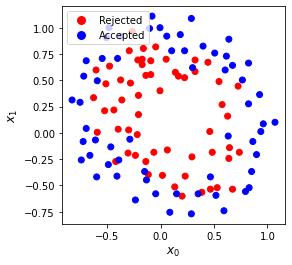

In [5]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(4,4))

# Create a list of colors based on y_train values
colors = ['blue' if y == 0 else 'red' for y in y_train]

ax.scatter(X_train[:,0], X_train[:,1], c=colors)

# Create a Legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Rejected', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Accepted', markerfacecolor='blue', markersize=10)]

ax.legend(handles=legend_elements, loc='upper left')

ax.set_xlabel('$x_0$', fontsize=12)
ax.set_ylabel('$x_1$', fontsize=12)
plt.show()

## Feature Mapping
One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot. 

In [6]:
def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features    
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)

In [7]:
print("Original Shape of the Data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after the Feature Mapping:", mapped_X.shape)

Original Shape of the Data: (118, 2)
Shape after the Feature Mapping: (118, 27)


In [8]:
print("X_train[0]:\n", X_train[0])
print("mapped X_train[0]:\n", mapped_X[0])

X_train[0]:
 [0.051267 0.69956 ]
mapped X_train[0]:
 [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


## Cost Function:  Regularized Log-Loss (Regularized Binary Cross-Entropy Loss)
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [10]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns:
      total_cost (scalar):  cost 
    """
    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      #(n,)(n,)=scalar, see np.dot
        f_wb_i = sigmoid(z_i)                                          #scalar
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      #scalar
             
    cost = cost/m                                                      #scalar

    reg_cost = 0
    for j in range(n):
        reg_cost += (w[j]**2)                                          #scalar
    reg_cost = (lambda_/(2*m)) * reg_cost                              #scalar
    
    total_cost = cost + reg_cost                                       #scalar
    return total_cost 

In [11]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])

np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized Cost :", cost)

Regularized Cost : 0.6618252552483948


## Regularized Batch Gradient Descent 
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace \text{simultaneous updates}
\end{align*}$$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$
$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})$$

In [12]:
def compute_gradient_reg(X, y, w, b, lambda_): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns
      dj_dw (ndarray Shape (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)            : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                            #(n,)
    dj_db = 0.0                                       #scalar

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] += err_i * X[i,j]                #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar

    for j in range(n):
        dj_dw[j] += (lambda_/m) * w[j]

    return dj_db, dj_dw  

In [13]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])

np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First Few Elements of Regularized dj_dw:\n {dj_dw[:4].tolist()}", )

dj_db: 0.07138288792343656
First Few Elements of Regularized dj_dw:
 [-0.010386028450548703, 0.011409852883280122, 0.0536273463274574, 0.003140278267313462]


In [14]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (ndarray Shape (m, n) data, m examples by n features
      y :    (ndarray Shape (m,))  target value 
      w_in : (ndarray Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)              Initial value of parameter of the model
      cost_function :              function to compute cost
      gradient_function :          function to compute gradient
      alpha : (float)              Learning rate
      num_iters : (int)            number of iterations to run gradient descent
      
    Returns:
      w : (ndarray Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    # Number of Training Examples
    m = len(X)
    
    # Store Cost J and w's at Each Iteration 
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the Gradient and Update the Parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, Alpha and Gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save Cost J at Each Iteration
        if i<100000: # Prevent Resource Exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print Cost
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history 

In [15]:
# Initialize Fitting Parameters
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set Regularization Parameter Lambda_ 
lambda_ = 0.01    

# Some Gradient Descent Settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

print(f"\nUpdated Parameters:\n w:\n{w}\nb:\n{b}")

Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45   

Updated Parameters:
 w:
[ 0.91430359  1.4923378  -2.59208306 -1.0206783  -1.70874963 -0.09508199
 -0.70729902 -0.45522579 -0.2625241  -1.50258859 -0.14183125 -0.44103606
 -0.5216627  -0.85782008 -0.62213889 -0.0730526  -0.11749311 -0.22665893
 -0.62206091 -0.81773062 -0.81412362  0.47440112 -0.48661532  0.20171914
  0.03665575  0.27726316 -1.43466503]
b:
1.43411872285427


In [16]:
# Plotting the Decision Boundary

def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)

    

def plot_decision_boundary(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code
     
    plot_data(X[:, 0:2], y)
    
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        
        plt.plot(plot_x, plot_y, c="b")
        
    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sigmoid(np.dot(map_feature(u[i], v[j]), w) + b)
        
        # important to transpose z before calling contour       
        z = z.T
        
        # Plot z = 0.5
        plt.contour(u,v,z, levels = [0.5], colors="g")

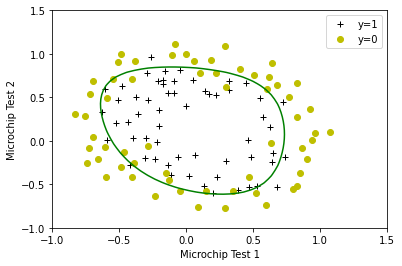

In [17]:
plot_decision_boundary(w, b, X_mapped, y_train)

plt.xlabel('Microchip Test 1') 
plt.ylabel('Microchip Test 2') 
plt.legend(loc="upper right")
plt.show()

## Evaluation
- Compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)} + b)$ for each example 
- To get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, use the following heuristic -

  If $f(x^{(i)}) >= 0.5$, Predict $y^{(i)}=1$
  
  If $f(x^{(i)}) < 0.5$, Predict $y^{(i)}=0$

In [18]:
def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w.
    
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model      
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """
    # Number of Training Examples
    m, n = X.shape   
    p = np.zeros(m)
   
    for i in range(m):
        z_wb_i = np.dot(w, X[i, :]) + b
        f_wb_i = sigmoid(z_wb_i)
        
        p[i] = f_wb_i >= 0.5
        
    return p

In [19]:
# Compute the Accuracy on our Training Set
p = predict(X_mapped, w, b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 82.203390
